## THIS NOTEBOOK USED FOR FINAL RESULTS FOR THIS MODEL. ALL SCREENSHOTS INCLUDED IN THE REPORT AND RESULTS PRESENT IN THIS NOTEBOOK

##### **Our Project**

For our project, we decided to present 4 models our our text classification problem. The end goal for our project is to compare all four models and pick which one performed the best. 

For this project, I picked SVM to perform on the dataset. 

Scoring metric to be used is F1 score.

#### **Goals for this notebook:**

* Perform cleaning and prepping of data
* Choose a metric for scoring
* Go through SVM model for text classification

## Note that I am not using the processed file that I have created in my previous notebooks. I am using the one processed by Ganesh. 


In [4]:
# from google.colab import files
# uploaded = files.upload()


In [5]:

# !unzip processed_complaints.zip -d processed_complaints.csv


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
# import nltk
# from nltk import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
# stop_words = stopwords.words('english')

In [7]:
# Loading the processed dataset created in the '02_Data_Exploration_Anshul_Shandilya' notebook.
df = pd.read_csv('processed_complaints.csv')

In [8]:
df.shape

(1112420, 3)

In [9]:
df.head()

,Unnamed: 0,Product,Complaint
0,38,Debt Collection,owe money never received bill indicating balan...
1,39,Debt Collection,attempting collect fund valuation service prov...
2,41,Credit Reporting and Services,experian didnt consent inquiry also name incor...
3,68,Banking Services,citibank froze account contained time make col...
4,129,Credit Reporting and Services,accordance fair credit reporting act account v...


In [10]:
# Change Complaint column to narrative
df = df.rename(columns={'Product':'product','Complaint':'narrative'})

In [11]:
df.head()

,Unnamed: 0,product,narrative
0,38,Debt Collection,owe money never received bill indicating balan...
1,39,Debt Collection,attempting collect fund valuation service prov...
2,41,Credit Reporting and Services,experian didnt consent inquiry also name incor...
3,68,Banking Services,citibank froze account contained time make col...
4,129,Credit Reporting and Services,accordance fair credit reporting act account v...


In [12]:
df.loc[345]['narrative']


'time try fix issue transunion contact retained credit reporting agency transunion continued allow account report name materially false fraudulent account also sending registered mail agency dependent outcome choose next legal step please cease desist reporting account failure fulfill fiduciary duty data furnisher inevitably result lawsuit filed behalf fiduciary duty fcra b respond within business day receipt fcra b read consumer reporting agency shall block reporting information file consumer later business day date receipt'

Here, we still have the narrative text in normal text. Let's see if we can do something about it.

In [13]:
len(df)

1112420

Since working on this dataset, the dataset is huge. So we will work only on randomly selected sample from the original dataset.

In [14]:
sample_size = 100000
sample_df = df.sample(sample_size, random_state=42)
sample_df.reset_index(inplace=True)

In [15]:
sample_df.head()
print(sample_df.shape)

(100000, 4)


##### Saving the sample dataset.

Now that we have the processed complaints with processed narrative, we will save it

In [16]:
sample_df.shape

(100000, 4)

In [17]:
sample_df.isnull().sum()
sample_df.dropna(inplace=True)

Now, we have loaded the dataset. Probably 'sub_product', 'Issue' and 'sub_issue' rows are redundant for our initial work as I only plan to use the 'product' as the class labels and the 'narrative' as the training data. 

##### Initial Steps using the SVC algorithm:

* Extract the labels using preprocessing.LabelEncoder()
* Split the data using the train_test_split() function into 20% test size and the rest as training data. Shuffle will we set as True to randomise the data
* Use the 'narrative' row as our training data
* Build the initial model

Extracting the labels

In [18]:
encoded_labels = preprocessing.LabelEncoder()
labels = encoded_labels.fit_transform(sample_df['product'])

In [19]:
labels.shape

(99992,)

Splitting the data into test and train data (20% test)

In [20]:
# Splitting the dataset into train and test sets.
x_train, x_test, y_train, y_test = train_test_split(sample_df['narrative'], labels, stratify = labels, test_size=0.2, random_state=47, shuffle=True)

In [21]:
print(x_train.shape)
print(x_test.shape)

(79993,)
(19999,)


##### Now that we have our train and test data, we will build a model.

In [22]:
# Function to plot the prediced values against the actual values
def plot_actual_vs_predicted(actual, predicted):
    figure, ax = plt.subplots()
    ax.scatter(actual, predicted, edgecolors=(0, 0, 0))
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.show()

First, I will initialise a TF-IDF model.

In [23]:
tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words = 'english')

Now, I will apply the TF-IDF model on both the test and train data (will take time since the num. of data is high)

In [24]:
tfidf.fit(list(x_train) + list(x_test))

TfidfVectorizer(min_df=3, ngram_range=(1, 3), smooth_idf=1,
                stop_words='english', strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [25]:
x_train_tfidf =  tfidf.transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

Comment either cell above or below depending on what you need to do.

##### **Training the SVM model**



I learned that SVM model takes a lot of time to run. Especially with close to 90000 components, it probably won't end before at least a couple of hours. So need to reduce the number of components before I proceed.

Reducing the number of components. (Using Singular Value Decomposition)

Initially, will try reducing to 300 components. 

In [26]:
# Initializing and applying SVD on the TF-IDF vectorized data to reduce the num. of components to 250.
svd = TruncatedSVD(n_components=250)
svd.fit(x_train_tfidf)
x_train_svd = svd.transform(x_train_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

Now that we have the components reduced (using SVD), since SMV is a linear model, we need to normalize the data before we try to fit the data into SVM.

In [27]:
# Normalizing the data using StandardScaler.
scl = preprocessing.StandardScaler()
scl.fit(x_train_svd)
x_train_svd_scl = scl.transform(x_train_svd)
x_test_svd_scl = scl.transform(x_test_svd)

In [28]:
# Creating and traininng a SVC model
svm_model = SVC(C=1.0, probability=True)
svm_model.fit(x_train_svd_scl, y_train)
preds = svm_model.predict(x_test_svd_scl)


In [33]:
preds_train = svm_model.predict(x_train_svd_scl)



In [34]:
# Printing the F-1 score
print("F1 score on train set: ", metrics.f1_score(y_train, preds_train, average='weighted'))
print("F1 score on test set: ", metrics.f1_score(y_test, preds, average='weighted'))


F1 score on train set:  0.8858307393589558
F1 score on test set:  0.8568457194587547


# USED AS FIGURE 3.2.1 IN THE REPORT FOR SVM

In [35]:
print("Classification report on train set: ")
print(metrics.classification_report(y_train, preds_train))

Classification report on train set: 
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      7038
           1       0.91      0.94      0.93     39138
           2       0.84      0.80      0.82      7468
           3       0.00      0.00      0.00         3
           4       0.85      0.81      0.83     13834
           5       0.83      0.74      0.79      5473
           6       0.92      0.91      0.92      7039

    accuracy                           0.89     79993
   macro avg       0.75      0.73      0.74     79993
weighted avg       0.89      0.89      0.89     79993



/home/ankur/mambaforge-pypy3/envs/fastai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ankur/mambaforge-pypy3/envs/fastai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ankur/mambaforge-pypy3/envs/fastai/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

# USED AS FIGURE 3.2.2 IN THE REPORT FOR SVM

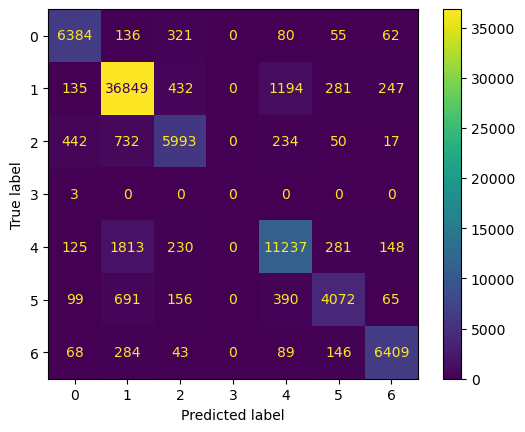

In [37]:
# Make a confusion matrix
cm = metrics.confusion_matrix(y_train, preds_train)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
plt.show()

In [30]:
y_train.shape
y_test.shape

(19999,)

In [1]:
# # Load pickle model
# import pickle
# filename = 'svm_model.pkl'
# pickle.dump(svm_model, open(filename, 'wb'))


NameError: name 'svm_model' is not defined

In [31]:
preds.shape

(19999,)

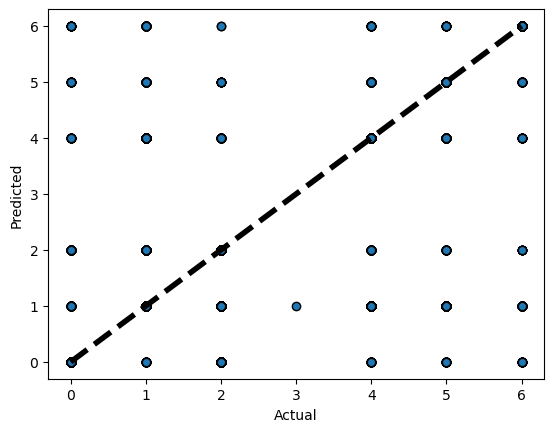

In [32]:
# Plot the predicted values against the actual values.
# plot_actual_vs_predicted(y_test, preds)

#### **Observations:**

* For sample_size=10000, 

    * **SVM** - F1 score = 0.8347134811772894

<br>

Since I took 10,000 samples, which is a fraction of close to million columns of data, I re-tried the same process with 100,000 samples.

* For sample_size=100,000, 

    * **SVM** - F1 score = 0.8550971142924789
    
    